# Predict Bike Sharing Demand with AutoGluon

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

### Setup Kaggle API Key

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

In [5]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir .kaggle

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

The syntax of the command is incorrect.
'touch' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "FILL_IN_USERNAME"
kaggle_key = "FILL_IN_KEY"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [9]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip


  0%|          | 0.00/189k [00:00<?, ?B/s]
100%|##########| 189k/189k [00:00<00:00, 362kB/s]
100%|##########| 189k/189k [00:00<00:00, 362kB/s]


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
from zipfile import ZipFile
with ZipFile('bike-sharing-demand.zip') as myzip:
    myzip.extractall()

In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [112]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv',)
train['datetime'] = pd.to_datetime(train['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [16]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [113]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv')
test['datetime'] = pd.to_datetime(test['datetime'])
test.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [20]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [18]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission['datetime'] = pd.to_datetime(submission['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [86]:
predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error',
                             learner_kwargs={'ignored_columns':['casual', 'registered']}).fit(
    train,time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220716_140736\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220716_140736\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:   

	-55.0512	 = Validation score   (-root_mean_squared_error)
	7.13s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L2 ... Training model for up to 188.85s of the 188.84s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-56.4273	 = Validation score   (-root_mean_squared_error)
	86.26s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 99.19s of the 99.18s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-54.6801	 = Validation score   (-root_mean_squared_error)
	8.36s	 = Training   runtime
	0.28s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 86.95s of remaining time.
	-50.5084	 = Validation score   (-root_mean_squared_error)
	0.34s	 = Training   runtime
	0.0s	 = Validation runtime
Au

### Review AutoGluon's training run with ranking of models that did the best.

In [87]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.508404       4.320824  320.569581                0.000000           0.342054            3       True         22
1   NeuralNetFastAI_BAG_L2  -51.644746       3.166570  305.338271                0.290064          21.891903            2       True         18
2   RandomForestMSE_BAG_L2  -53.362934       3.310604  288.369476                0.434098           4.923108            2       True         15
3     ExtraTreesMSE_BAG_L2  -54.064339       3.316605  285.053729                0.440099           1.607362            2       True         17
4     LightGBMLarge_BAG_L2  -54.680075       3.156564  291.805154                0.280058           8.358786            2       True         21
5          LightGBM_BAG_L2  -55.036681       3.064479  287.508160         

C:\ProgramData\Anaconda3\envs\ag\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFa

### Create predictions from test dataset

In [94]:
predictions = predictor.predict(test)
predictions.head()

0    25.009733
1    40.527004
2    45.532993
3    48.758602
4    50.972950
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [95]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean       99.834747
std        87.764580
min         0.771906
25%        22.121367
50%        68.509857
75%       165.775284
max       350.437866
Name: count, dtype: float64

In [92]:
# How many negative values do we have?
predictions[predictions < 0].count()

0

In [93]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [98]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [97]:
submission

,datetime,count
0,2011-01-20 00:00:00,25.009733
1,2011-01-20 01:00:00,40.527004
2,2011-01-20 02:00:00,45.532993
3,2011-01-20 03:00:00,48.758602
4,2011-01-20 04:00:00,50.972950
...,...,...
6488,2012-12-31 19:00:00,165.538177
6489,2012-12-31 20:00:00,165.542130
6490,2012-12-31 21:00:00,156.507294
6491,2012-12-31 22:00:00,152.325943


In [99]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/195k [00:00<?, ?B/s]
  4%|4         | 8.00k/195k [00:00<00:04, 47.5kB/s]
 53%|#####3    | 104k/195k [00:00<00:00, 434kB/s]  
 82%|########2 | 160k/195k [00:00<00:00, 418kB/s]
100%|##########| 195k/195k [00:01<00:00, 115kB/s]


#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [104]:
!kaggle competitions submissions -c bike-sharing-demand 

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2022-07-16 15:18:04  first raw submission  complete  1.77523      1.77523       


#### Initial score of 1.77532

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

In [102]:
%matplotlib inline

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

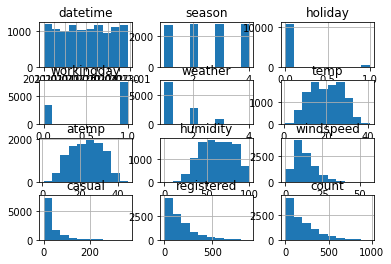

In [103]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [114]:
# create a new feature
train['hour'] = train['datetime'].dt.hour

test['hour'] = test['datetime'].dt.hour

In [115]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [116]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [119]:
# View are new feature
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  hour        10886 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(3), int64(7)
memory usage: 957.3 KB


array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>],
       [<AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>],
       [<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'hour'}>, <AxesSubplot:>]],
      dtype=object)

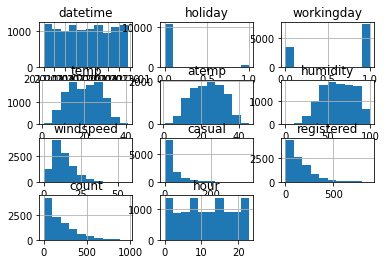

In [118]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [120]:
predictor_new_features = TabularPredictor(
    label='count',eval_metric='root_mean_squared_error', learner_kwargs={'ignored_columns':["casual", "registered"]}
).fit(train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220716_154110\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220716_154110\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:   

	0.28s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 605.32s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220716_154110\")


In [121]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -29.121460      33.640713  541.606024                0.001000           0.279063            3       True         19
1   NeuralNetFastAI_BAG_L2  -29.284484      33.141592  392.753459                0.349083          23.274814            2       True         17
2          CatBoost_BAG_L2  -30.547095      32.865547  510.650677                0.073037         141.172033            2       True         15
3          LightGBM_BAG_L2  -30.669437      33.093567  374.110134                0.301058           4.631490            2       True         13
4        LightGBMXT_BAG_L2  -30.947730      33.607688  375.249020                0.815178           5.770375            2       True         12
5           XGBoost_BAG_L2  -31.012501      32.916535  372.248624         

C:\ProgramData\Anaconda3\envs\ag\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleMode

In [124]:
predictions_new_feature = predictor_new_features.predict(test)

In [125]:
predictions_new_feature.describe()

count    6493.000000
mean      136.920883
std       109.493500
min        -1.709463
25%        54.715214
50%       114.892494
75%       184.219940
max       739.368591
Name: count, dtype: float64

In [130]:
# How many negative values do we have?
predictions_new_feature[predictions_new_feature < 0].count()

0

In [129]:
# Remember to set all negative values to zero
predictions_new_feature[predictions_new_feature < 0] = 0

In [133]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv')
submission_new_features['datetime'] = pd.to_datetime(submission_new_features['datetime'])
submission_new_features["count"] = predictions_new_feature
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [134]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

Successfully submitted to Bike Sharing Demand


  0%|          | 0.00/195k [00:00<?, ?B/s]
  4%|4         | 8.00k/195k [00:00<00:03, 51.6kB/s]
 53%|#####3    | 104k/195k [00:00<00:00, 459kB/s]  
100%|##########| 195k/195k [00:00<00:00, 634kB/s]
100%|##########| 195k/195k [00:02<00:00, 91.5kB/s]


In [135]:
!kaggle competitions submissions -c bike-sharing-demand

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2022-07-16 16:04:54  new features          complete  0.77945      0.77945       
submission.csv               2022-07-16 15:18:04  first raw submission  complete  1.77523      1.77523       


#### New Score of `0.77945`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [136]:
# this code is provided by the aoutogluon Documentation
# Link: https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-indepth.html

import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

In [137]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [139]:
predictor_new_hpo = TabularPredictor(
    label='count', eval_metric='root_mean_squared_error',  learner_kwargs={'ignored_columns':["casual", "registered"]}
).fit(train, time_limit=600, presets='best_quality', 
      hyperparameter_tune_kwargs=hyperparameter_tune_kwargs, hyperparameters=hyperparameters
     )

No path specified. Models will be saved in: "AutogluonModels/ag-20220716_164542\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220716_164542\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:   

  0%|          | 0/5 [00:00<?, ?it/s]

Fitted model: LightGBM_BAG_L1\T1 ...
	-39.5016	 = Validation score   (-root_mean_squared_error)
	0.51s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T2 ...
	-37.4217	 = Validation score   (-root_mean_squared_error)
	0.49s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T3 ...
	-36.9309	 = Validation score   (-root_mean_squared_error)
	0.54s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T4 ...
	-118.3072	 = Validation score   (-root_mean_squared_error)
	0.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T5 ...
	-41.8771	 = Validation score   (-root_mean_squared_error)
	0.51s	 = Training   runtime
	0.01s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L1 ... Tuning model for up to 22.49s of the 597.07s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L1\T1 ...
	-95.2906	 = Validation score   (-root_mean_squared_error)
	4.57s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L1\T2 ...
	-53.5584	 = Validation score   (-root_mean_squared_error)
	11.28s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM_BAG_L1\T1 ... Training model for up to 380.88s of the 580.95s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-40.2512	 = Validation score   (-root_mean_squared_error)
	3.04s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: LightGBM_BAG_L1\T2 ... Training model for up to 374.49s of the 574.56s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-39.177	 = Validation score   (-root_mean_squared_error)
	3.15s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: LightGBM_B

	Fitting 8 child models (S4F1 - S4F8) | Fitting with ParallelLocalFoldFittingStrategy
	-42.5746	 = Validation score   (-root_mean_squared_error)
	12.54s	 = Training   runtime
	0.57s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1\T1 ... Training model for up to 116.59s of the 316.66s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with ParallelLocalFoldFittingStrategy
	-94.5461	 = Validation score   (-root_mean_squared_error)
	42.7s	 = Training   runtime
	3.22s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1\T2 ... Training model for up to 100.38s of the 300.44s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with ParallelLocalFoldFittingStrategy
	-49.247	 = Validation score   (-root_mean_squared_error)
	119.55s	 = Training   runtime
	1.79s	 = Validation runtime
Completed 4/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 266.43s of remaining time.
	-37.4668	 = Validat

  0%|          | 0/5 [00:00<?, ?it/s]

Fitted model: LightGBM_BAG_L2\T1 ...
	-38.9154	 = Validation score   (-root_mean_squared_error)
	0.64s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T2 ...
	-37.8242	 = Validation score   (-root_mean_squared_error)
	0.54s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T3 ...
	-38.509	 = Validation score   (-root_mean_squared_error)
	0.63s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T4 ...
	-102.2042	 = Validation score   (-root_mean_squared_error)
	0.56s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T5 ...
	-39.1477	 = Validation score   (-root_mean_squared_error)
	0.56s	 = Training   runtime
	0.01s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L2 ... Tuning model for up to 14.96s of the 262.6s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Ran out of time, stopping training early. (Stopping on epoch 6)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L2\T1 ...
	-39.7101	 = Validation score   (-root_mean_squared_error)
	4.97s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2\T2 ...
	-40.9866	 = Validation score   (-root_mean_squared_error)
	6.46s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM_BAG_L2\T1 ... Training model for up to 250.85s of the 250.84s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-36.2727	 = Validation score   (-root_mean_squared_error)
	3.75s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: LightGBM_BAG_L2\T2 ... Training model for up to 244.74s of the 244.73s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-36.1929	 = Validation score   (-root_mean_squared_error)
	3.77s	 = Training

In [198]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -35.607563      11.320125  320.978044                0.001001           0.274062            3       True         16
1         LightGBM_BAG_L2\T3  -35.896809       7.908212  230.575884                0.275063           7.177558            2       True         11
2         LightGBM_BAG_L2\T2  -35.959129       7.870723  230.805062                0.237573           7.406736            2       True         10
3         LightGBM_BAG_L2\T1  -36.099843       7.875712  230.794398                0.242563           7.396071            2       True          9
4         LightGBM_BAG_L2\T5  -36.557463       7.891201  230.106931                0.258051           6.708605            2       True         13
5   NeuralNetTorch_BAG_L2\T1  -36.934847       9.853648  246.7

C:\ProgramData\Anaconda3\envs\ag\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM_BAG_L1\\T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1\\T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1\\T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1\\T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1\\T5': 'StackerEnsembleModel_LGB',
  'NeuralNetTorch_BAG_L1\\T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L1\\T2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2\\T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2\\T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2\\T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2\\T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2\\T5': 'StackerEnsembleModel_LGB',
  'NeuralNetTorch_BAG_L2\\T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L2\\T2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1\\T1': 

In [141]:
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    11.442290
1     6.096760
2     5.808981
3     5.371892
4     5.244337
Name: count, dtype: float32

In [144]:
predictions_new_hpo.describe()

count    6493.000000
mean      189.094635
std       172.741852
min         4.316188
25%        43.717487
50%       146.470581
75%       282.015778
max       860.656372
Name: count, dtype: float64

In [143]:
# Remember to set all negative values to zero
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [148]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv')
submission_new_hpo['datetime'] = pd.to_datetime(submission_new_hpo['datetime'])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [149]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/194k [00:00<?, ?B/s]
  4%|4         | 8.00k/194k [00:00<00:03, 49.3kB/s]
 53%|#####3    | 104k/194k [00:00<00:00, 453kB/s]  
100%|##########| 194k/194k [00:00<00:00, 621kB/s]
100%|##########| 194k/194k [00:02<00:00, 82.7kB/s]


In [150]:
!kaggle competitions submissions -c bike-sharing-demand

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-07-16 17:01:55  new features with hyperparameters  complete  0.46172      0.46172       
submission_new_features.csv  2022-07-16 16:04:54  new features                       complete  0.77945      0.77945       
submission.csv               2022-07-16 15:18:04  first raw submission               complete  1.77523      1.77523       


#### New Score of `0.4617`

## Try To add more features of date and ignore the first date

In [151]:
# create a new feature
train['hour'] = train['datetime'].dt.hour
train['day'] = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month

test['hour'] = test['datetime'].dt.hour
test['day'] = test['datetime'].dt.day
test['month'] = test['datetime'].dt.month

In [152]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [116]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [153]:
# View are new feature
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  hour        10886 non-null  int64         
 13  day         10886 non-null  int64         
 14  month       10886 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(3), int64(9)
memory usage: 

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>],
       [<AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>],
       [<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'hour'}>, <AxesSubplot:>]],
      dtype=object)

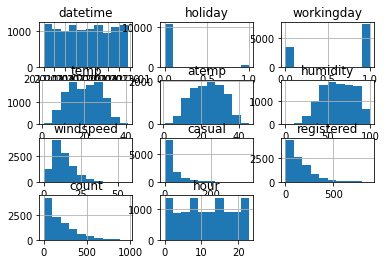

In [118]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [172]:
predictor_more_features = TabularPredictor(
    label='count',eval_metric='root_mean_squared_error', learner_kwargs={'ignored_columns':["casual", "registered","datetime"]}
).fit(train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220716_175019\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220716_175019\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered', 'datetime']
Fitting AutoMLPipelineFeatureGenerator...
	Availabl

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-51.2616	 = Validation score   (-root_mean_squared_error)
	6.75s	 = Training   runtime
	0.23s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the -5.99s of remaining time.
	-49.6585	 = Validation score   (-root_mean_squared_error)
	0.33s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 606.36s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220716_175019\")


In [173]:
predictor_more_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -49.658459     107.586134  522.831703                0.000000           0.326080            3       True         21
1   NeuralNetFastAI_BAG_L2  -50.277231     105.893221  380.307045                0.359080          24.409878            2       True         17
2          CatBoost_BAG_L2  -50.404802     105.580150  435.755391                0.046010          79.858225            2       True         15
3     ExtraTreesMSE_BAG_L2  -50.486664     106.040256  357.374013                0.506115           1.476846            2       True         16
4           XGBoost_BAG_L2  -50.832271     105.663163  361.486105                0.129023           5.588939            2       True         18
5   RandomForestMSE_BAG_L2  -50.838127     105.992224  360.791266         

C:\ProgramData\Anaconda3\envs\ag\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleMode

In [175]:
predictions_more_features = predictor_more_features.predict(test)

In [176]:
predictor_more_features.features()

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'hour',
 'day',
 'month']

In [177]:
predictions_more_features.describe()

count    6493.000000
mean      187.757217
std       164.291214
min        -3.457169
25%        48.915688
50%       150.285034
75%       272.099365
max       842.409912
Name: count, dtype: float64

In [178]:
# How many negative values do we have?
predictions_more_features[predictions_more_features < 0].count()

33

In [179]:
# Remember to set all negative values to zero
predictions_more_features[predictions_more_features < 0] = 0

In [180]:
# Same submitting predictions
submission_more_features = pd.read_csv('sampleSubmission.csv')
submission_more_features['datetime'] = pd.to_datetime(submission_more_features['datetime'])
submission_more_features["count"] = predictions_more_features
submission_more_features.to_csv("submission_more_features.csv", index=False)

In [181]:
!kaggle competitions submit -c bike-sharing-demand -f submission_more_features.csv -m "more features"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/194k [00:00<?, ?B/s]
  4%|4         | 8.00k/194k [00:00<00:04, 40.3kB/s]
 54%|#####3    | 104k/194k [00:00<00:00, 400kB/s]  
100%|##########| 194k/194k [00:00<00:00, 583kB/s]
100%|##########| 194k/194k [00:02<00:00, 89.7kB/s]


In [182]:
!kaggle competitions submissions -c bike-sharing-demand

fileName                      date                 description                        status    publicScore  privateScore  
----------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_more_features.csv  2022-07-16 18:08:22  more features                      complete  0.57067      0.57067       
submission_more_features.csv  2022-07-16 17:27:23  more features                      complete  0.73379      0.73379       
submission_new_hpo.csv        2022-07-16 17:01:55  new features with hyperparameters  complete  0.46172      0.46172       
submission_new_features.csv   2022-07-16 16:04:54  new features                       complete  0.77945      0.77945       
submission.csv                2022-07-16 15:18:04  first raw submission               complete  1.77523      1.77523       


#### New Score of 0.57067 

## Try change Hyperparameter with more features
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [209]:
# this code is provided by the aoutogluon Documentation
# Link: https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-indepth.html

import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

In [137]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [210]:
predictor_new_hpo_moref = TabularPredictor(
    label='count', eval_metric='root_mean_squared_error', learner_kwargs={'ignored_columns':["casual", "registered","datetime"]}
).fit(train, time_limit=600, presets='best_quality', 
      hyperparameter_tune_kwargs=hyperparameter_tune_kwargs, hyperparameters=hyperparameters
     )

No path specified. Models will be saved in: "AutogluonModels/ag-20220716_205231\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220716_205231\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered', 'datetime']
Fitting AutoMLPipelineFeatureGenerator...
	Availabl

  0%|          | 0/5 [00:00<?, ?it/s]

Fitted model: LightGBM_BAG_L1\T1 ...
	-65.9773	 = Validation score   (-root_mean_squared_error)
	2.82s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T2 ...
	-64.5647	 = Validation score   (-root_mean_squared_error)
	1.95s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T3 ...
	-64.8402	 = Validation score   (-root_mean_squared_error)
	2.88s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T4 ...
	-130.5306	 = Validation score   (-root_mean_squared_error)
	1.58s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T5 ...
	-68.365	 = Validation score   (-root_mean_squared_error)
	1.7s	 = Training   runtime
	0.02s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L1 ... Tuning model for up to 22.49s of the 588.14s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Ran out of time, stopping training early. (Stopping on epoch 7)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L1\T1 ...
	-122.0902	 = Validation score   (-root_mean_squared_error)
	17.73s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBM_BAG_L1\T1 ... Training model for up to 370.01s of the 570.04s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-120.2906	 = Validation score   (-root_mean_squared_error)
	25.13s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM_BAG_L1\T2 ... Training model for up to 339.0s of the 539.03s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-73.7215	 = Validation score   (-root_mean_squared_error)
	20.14s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: LightGBM_BAG_L1\T3 ... Training model for up to 311.94s of the 511.98s of remaining time.
	Fitting 7 

  0%|          | 0/5 [00:00<?, ?it/s]

Fitted model: LightGBM_BAG_L2\T1 ...
	-66.5858	 = Validation score   (-root_mean_squared_error)
	1.98s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T2 ...
	-66.5341	 = Validation score   (-root_mean_squared_error)
	1.8s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T3 ...
	-66.5206	 = Validation score   (-root_mean_squared_error)
	1.38s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T4 ...
	-111.328	 = Validation score   (-root_mean_squared_error)
	1.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T5 ...
	-66.9894	 = Validation score   (-root_mean_squared_error)
	0.9s	 = Training   runtime
	0.01s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L2 ... Tuning model for up to 21.38s of the 372.57s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Ran out of time, stopping training early. (Stopping on epoch 7)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L2\T1 ...
	-67.0878	 = Validation score   (-root_mean_squared_error)
	6.4s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2\T2 ...
	-67.228	 = Validation score   (-root_mean_squared_error)
	9.72s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM_BAG_L2\T1 ... Training model for up to 356.04s of the 356.03s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-65.6416	 = Validation score   (-root_mean_squared_error)
	4.71s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: LightGBM_BAG_L2\T2 ... Training model for up to 347.54s of the 347.52s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-65.2013	 = Validation score   (-root_mean_squared_error)
	5.38s	 = Training  

In [194]:
predictor_new_hpo_moref.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                        model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3  -52.015586      28.101751  481.566183                0.001005           0.310063            3       True         22
1        LightGBMLarge_BAG_L1  -52.592425       0.027005    4.806263                0.027005           4.806263            1       True         11
2   NeuralNetFastAI_BAG_L2\T1  -52.749224      26.834710  375.943936                0.500104          31.440280            2       True         18
3     ExtraTreesMSE_BAG_L2\T1  -52.909396      26.873519  346.171614                0.538914           1.667958            2       True         17
4         WeightedEnsemble_L2  -53.010209      24.797205   39.544293                0.001999           1.115186            2       True         12
5           XGBoost_BAG_L2\T1  -53.096093      26.477634

C:\ProgramData\Anaconda3\envs\ag\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1\\T1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1\\T1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1\\T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1\\T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1\\T1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1\\T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1\\T1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1\\T1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1\\T1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1\\T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2\\T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2\\T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2\\T1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2\\T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2\\T1': 'StackerEnsembleModel

In [211]:
predictions_new_hpo_moref = predictor_new_hpo_moref.predict(test)
predictions_new_hpo_moref.head()

0    22.521484
1     9.923033
2     8.674217
3     8.573597
4     8.646904
Name: count, dtype: float32

In [214]:
predictions_new_hpo_moref.describe()

count    6493.000000
mean      183.227631
std       156.579376
min         7.303747
25%        47.932755
50%       145.728302
75%       273.152679
max       711.331421
Name: count, dtype: float64

In [215]:
# Remember to set all negative values to zero
predictions_new_hpo_moref[predictions_new_hpo_moref < 0] = 0

In [216]:
predictor_new_hpo_moref.features()

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'hour',
 'day',
 'month']

In [217]:
# Same submitting predictions
submission_new_hpo_moref = pd.read_csv('sampleSubmission.csv')
submission_new_hpo_moref['datetime'] = pd.to_datetime(submission_new_hpo_moref['datetime'])
submission_new_hpo_moref["count"] = predictions_new_hpo_moref
submission_new_hpo_moref.to_csv("submission_new_hpo_moref3.csv", index=False)

In [218]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo_moref3.csv -m "more features with hyperparameters3"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/195k [00:00<?, ?B/s]
  4%|4         | 8.00k/195k [00:00<00:04, 39.4kB/s]
 53%|#####3    | 104k/195k [00:00<00:00, 390kB/s]  
100%|##########| 195k/195k [00:00<00:00, 569kB/s]
100%|##########| 195k/195k [00:01<00:00, 101kB/s]


In [219]:
!kaggle competitions submissions -c bike-sharing-demand

fileName                       date                 description                          status    publicScore  privateScore  
-----------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo_moref3.csv  2022-07-16 21:04:27  more features with hyperparameters3  complete  0.53766      0.53766       
submission_new_hpo_moref2.csv  2022-07-16 20:42:55  more features with hyperparameters2  complete  0.56856      0.56856       
submission_new_hpo_moref.csv   2022-07-16 18:21:53  more features with hyperparameters   complete  0.46172      0.46172       
submission_more_features.csv   2022-07-16 18:08:22  more features                        complete  0.57067      0.57067       
submission_more_features.csv   2022-07-16 17:27:23  more features                        complete  0.73379      0.73379       
submission_new_hpo.csv         2022-07-16 17:01:55  new features with hyperparameters    complete  0.46172     

#### New Score of `0.5376`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

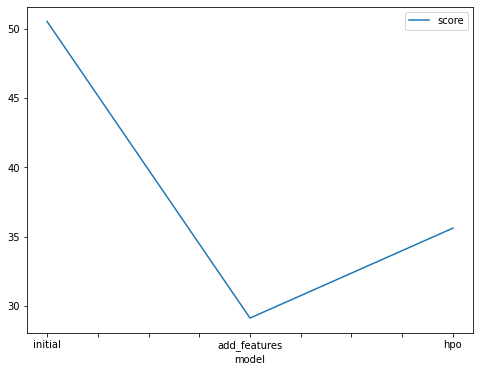

In [2]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [50.508404, 29.121460, 35.607563]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

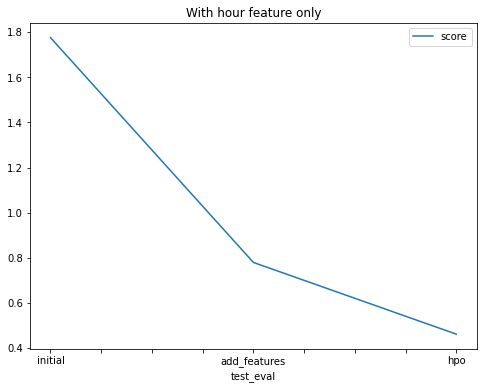

In [9]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.77523, 0.77945, 0.46172]
    }
).plot(x="test_eval", y="score", figsize=(8, 6), title='With hour feature only').get_figure()
fig.savefig('model_test_score.png')

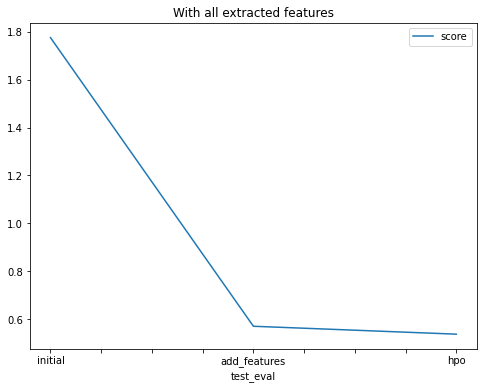

In [8]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame({"test_eval": ["initial", "add_features", "hpo"],"score": [1.77523, 0.57067 , 0.53766]}
                  ).plot(x="test_eval", y="score", figsize=(8, 6), title='With all extracted features').get_figure()
fig.savefig('model_test_score2.png')

### Hyperparameter table

In [3]:
# With adding hour feature only
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['default', 'default', 'GPM: (num_leaves: lower=26, upper=66), num_boost_round: 100'],
    "hpo2": ['default', 'default', 'NN: num_epochs: 10'],
    "hpo3": ['default', 'default', 'num_trials = 5, searchstrategy= auto'],
    "score": [1.77523, 0.77945, 0.46172]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.77523
1,add_features,default,default,default,0.77945
2,hpo,"GPM: (num_leaves: lower=26, upper=66), num_boo...",NN: num_epochs: 10,"num_trials = 5, searchstrategy= auto",0.46172


In [10]:
# With adding all extracted features
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['default', 'default', 'GPM: (num_leaves: lower=26, upper=66), num_boost_round: 100'],
    "hpo2": ['default', 'default', 'NN: num_epochs: 10'],
    "hpo3": ['default', 'default', 'num_trials = 5, searchstrategy= auto'],
    "score":  [1.77523, 0.57067 , 0.53766]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.77523
1,add_features,default,default,default,0.57067
2,hpo,"GPM: (num_leaves: lower=26, upper=66), num_boo...",NN: num_epochs: 10,"num_trials = 5, searchstrategy= auto",0.53766
